In [1]:
import cv2
import numpy as np
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
import csv
%matplotlib inline
from matplotlib import pyplot as plt
from pygam import GAM, LinearGAM, s, f, te

from alice.east import EastTextDetection



In [2]:


# Load the image
image = cv2.imread("image2.jpg")

def dewarp_text(image, n_splines = 5):
    # Grayscale it, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)  

    # scatter = []

    # # Write in csv file
    # for x in range(thresh.shape[0]):
    #     for y in range(thresh.shape[1]):
    #         # Search for black pixels
    #         if (thresh[x][y] <= 128):
    #             scatter.append({
    #                 'Y': y,
    #                 'X': thresh.shape[0] - x
    #             })

    # df = pd.DataFrame(scatter)


    # Open csv file
    f = open('./scatterplot_records.csv', 'w')
    
    # Create the csv writer
    writer = csv.writer(f)
    writer.writerow(['X', 'Y'])
    
    # Write in csv file
    for x in range(thresh.shape[0]):
        for y in range(thresh.shape[1]):
          # Search for black pixels
          if (thresh[x][y] <= 128):
            #writer.writerow([y, x])                        # reverse/mirrored scatter-plot image
            writer.writerow([y, thresh.shape[0] - x])       # normal scatter-plot image
    
    # Close csv file
    f.close()
    
    # Read CSV file and extract info
    df = pd.read_csv('./scatterplot_records.csv', sep = ",")
    
    # Delete csv file
    os.remove('./scatterplot_records.csv')
    
    # Build GAM & define its parameters
    predictors = ['X']
    outcome = ['Y']
    X = df[predictors].values
    y = df[outcome]
    gam = LinearGAM(n_splines = n_splines)
    gam.gridsearch(X, y)
    
    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(np.linspace(0, thresh.shape[1], num = thresh.shape[1]))
  
    # # Plot the image with text curve overlay
    # plt.imshow(image)
    # plt.plot(np.linspace(0, thresh.shape[1], num=thresh.shape[1]), (thresh.shape[0] - y_hat), color='red')
    # plt.show()

    # Roll each column to align the text
    for i in range(image.shape[1]):
        image[:, i] = np.roll(image[:, i], round(y_hat[i] - thresh.shape[0]/2))
        # image[:, i, 0] = np.roll(image[:, i, 0], round(y_hat[i] - thresh.shape[0]/2))
        # image[:, i, 1] = np.roll(image[:, i, 1], round(y_hat[i] - thresh.shape[0]/2))
        # image[:, i, 2] = np.roll(image[:, i, 2], round(y_hat[i] - thresh.shape[0]/2))

    return image


# dewarped = dewarp_text(image)

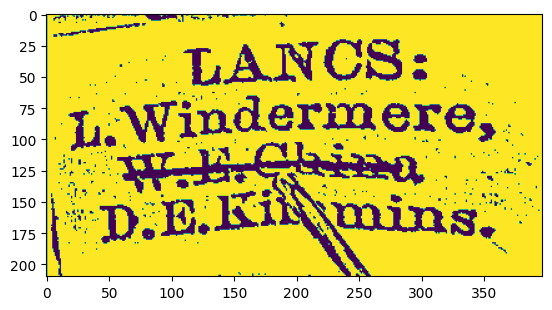

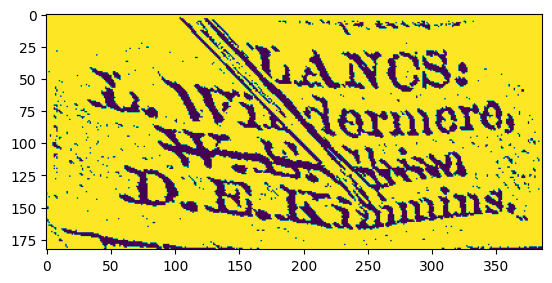

(<matplotlib.image.AxesImage at 0x13a782ef0>, None)

In [3]:
from skimage.filters import threshold_local

image1 = cv2.imread("image1.jpg")
image2 = cv2.imread("image2.jpg")

def threshold_image(image):

    cutoff_val = 200 # everything above this is set to the cutoff val
    set_color = 255 
    ret,thresh_img = cv2.threshold(image,cutoff_val,255,cv2.THRESH_TRUNC)
    window_size = 11
    thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(thresh_img,set_color,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,window_size,2)

img1 = threshold_image(image1.copy())
img2 = threshold_image(image2.copy())


plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

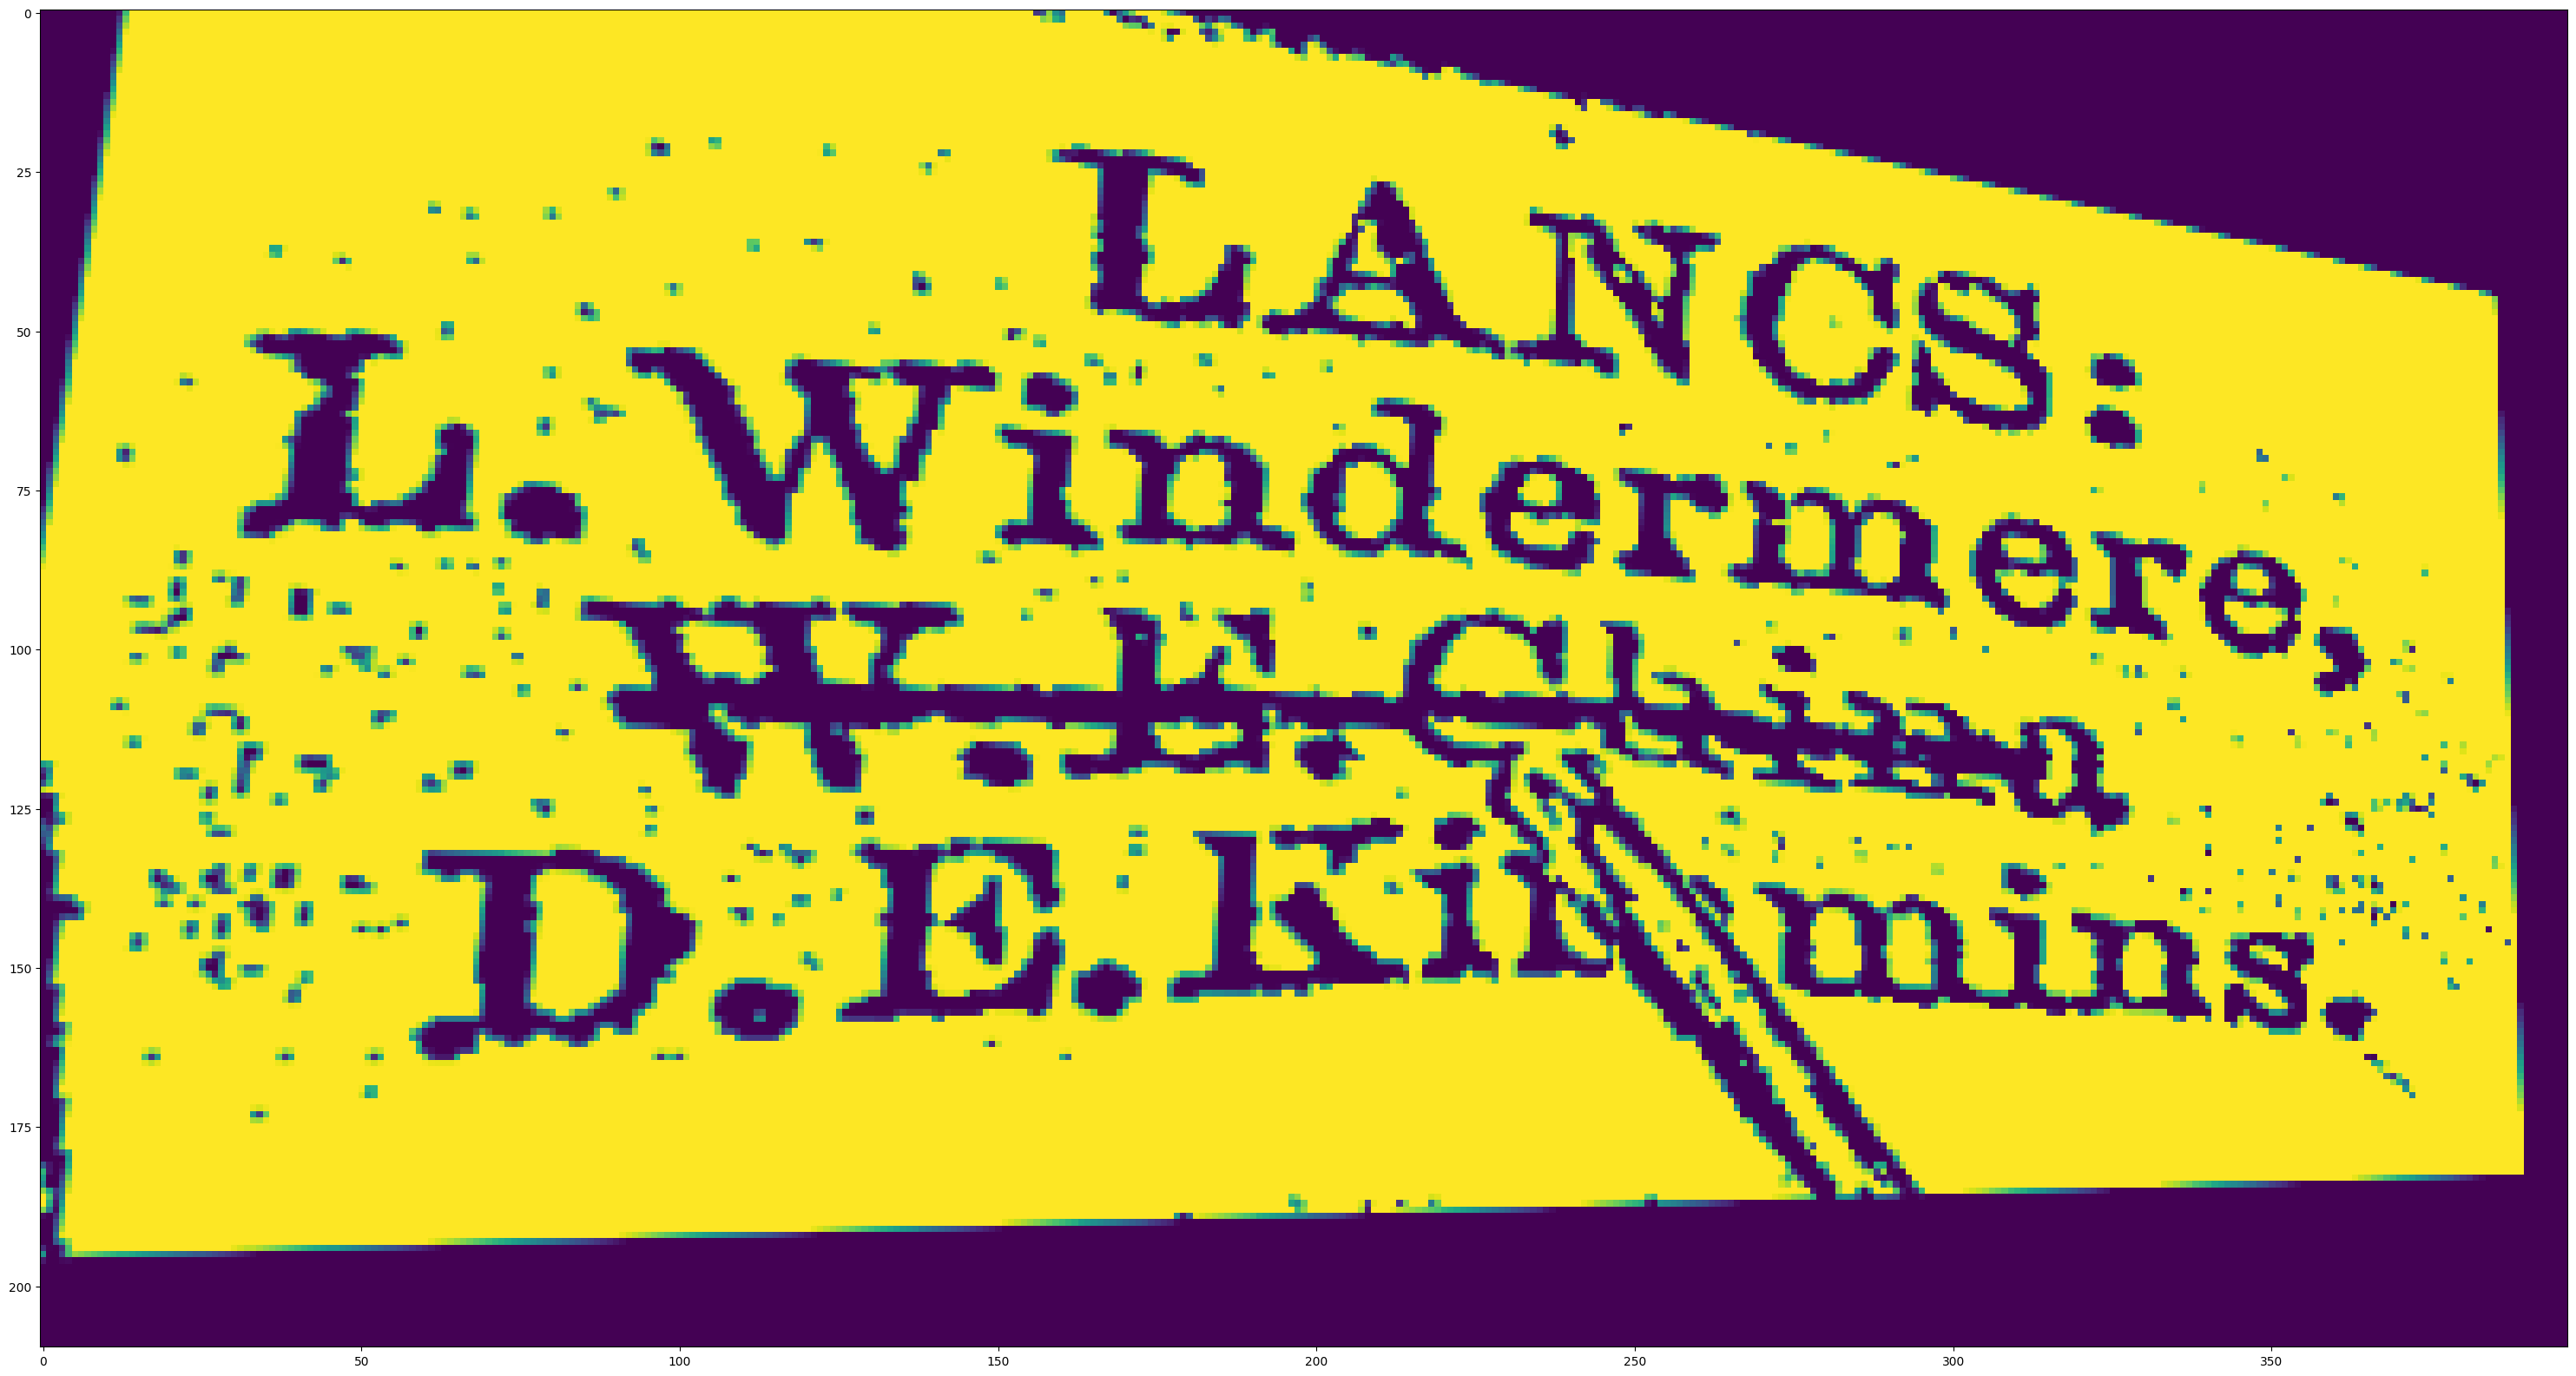

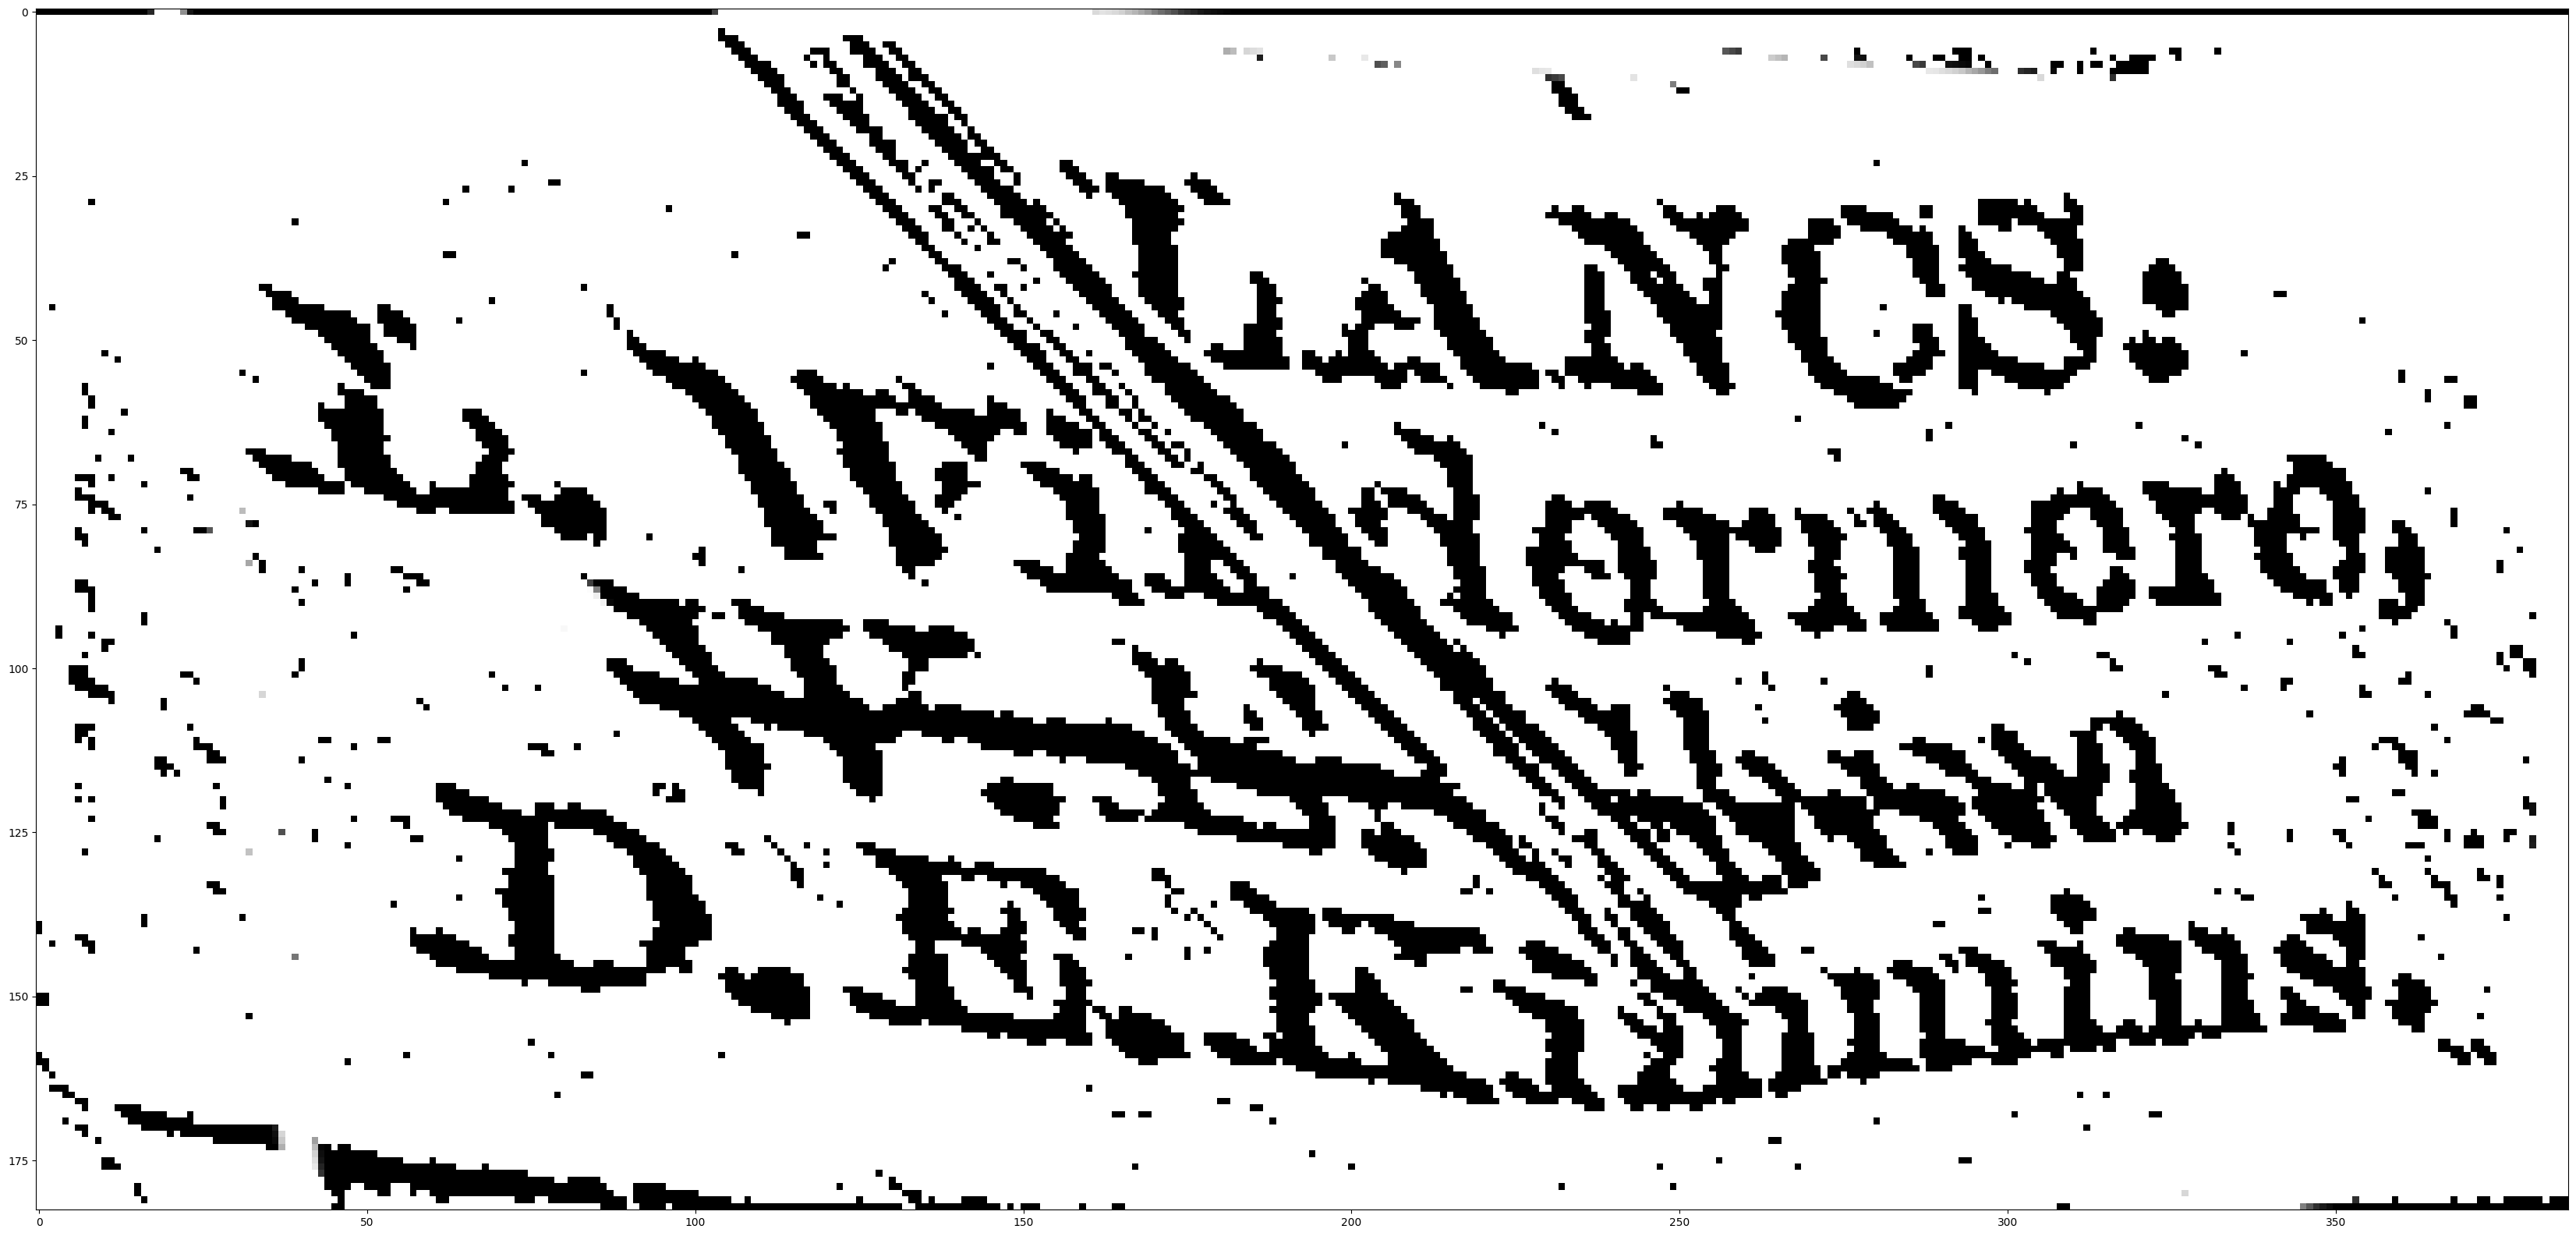

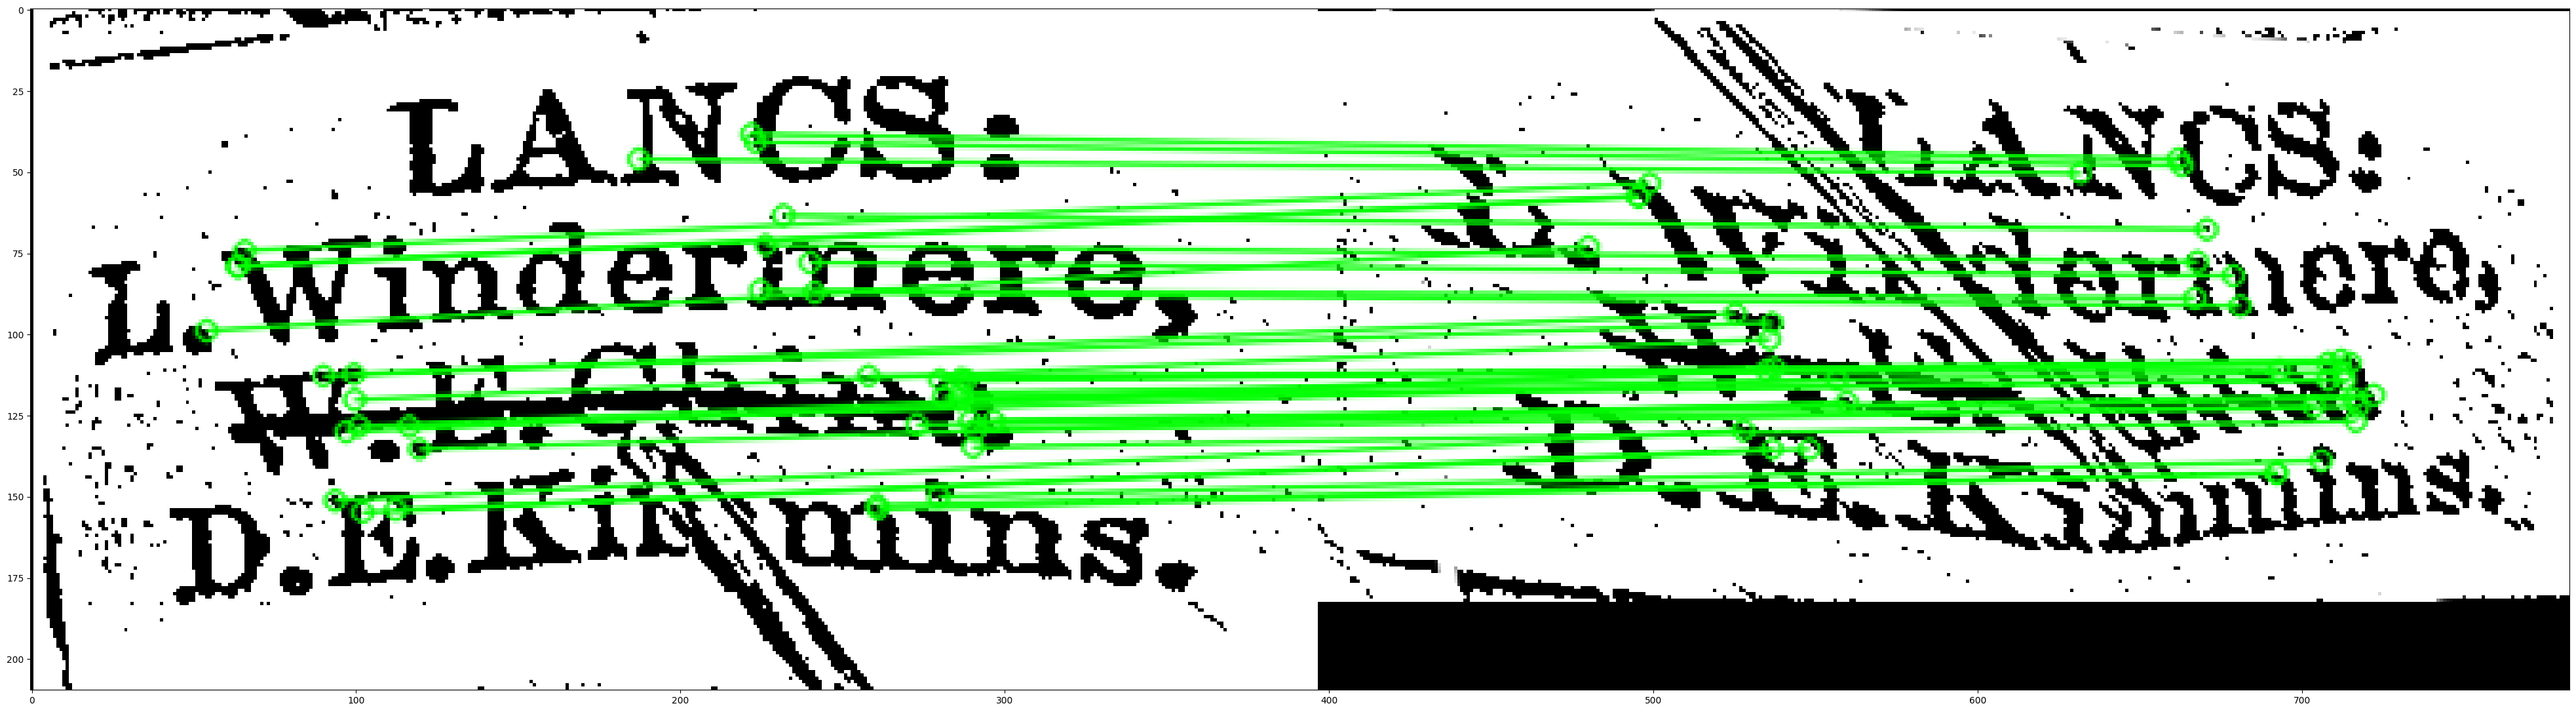

In [27]:
def sift_detector(image1, image2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create(10000)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1,des2,k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return kp1, kp2, good          

def beblid(img1, img2):

    detector = cv2.ORB_create(10000)
    kpts1 = detector.detect(img1, None)
    kpts2 = detector.detect(img2, None)
    
    # descriptor = cv.ORB_create()
    descriptor = cv2.xfeatures2d.BEBLID_create(0.75)
    kpts1, desc1 = descriptor.compute(img1, kpts1)
    kpts2, desc2 = descriptor.compute(img2, kpts2)    

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    matches = matcher.knnMatch(desc1, desc2, 2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    return kpts1, kpts2, good       
    

kp1, kp2, good = beblid(img1, img2)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# transformed_img = cv2.warpPerspective(image1, homography, (width, height))

transformed_img = cv2.warpPerspective(img1, M, (w, h))


# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# print(good)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize = (50,20))
plt.imshow(transformed_img)
plt.show()

plt.figure(figsize = (50,20))
plt.imshow(img2, 'gray')
plt.show()


plt.figure(figsize = (50,20))
plt.imshow(img3, 'gray')
plt.show()



In [ ]:
# dewarped = dewarp_text(thresh_img2)

In [ ]:
# plt.imshow(dewarped)
# plt.show() 

In [ ]:
# east = EastTextDetection()   

# image1 = images[2].copy()
# boxes1, lines1 = east.detect(thresh_img2)

In [ ]:
from skimage.filters import threshold_local

image = image2.copy()
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# T = threshold_local(gray, 21, offset = 10, method = "gaussian")
# gray = (gray > T).astype("uint8") * 255

# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cutoff_val = 200 # everything above this is set to the cutoff val
set_color = 255 # if 
ret,thresh_img = cv2.threshold(image,cutoff_val,set_color,cv2.THRESH_TRUNC)
window_sz = 11
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
thresh_img2 = cv2.adaptiveThreshold(thresh_img,set_color,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,window_sz,2)
# # Load the image in grayscale
# # image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)

# # Apply adaptive thresholding
# thresholded = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(thresh_img2), plt.show()

In [ ]:
img = image.copy()

for start, end in boxes1:
    cv2.rectangle(img, start, end, (0, 255, 255), 2)

plt.imshow(img), plt.show()


In [ ]:
descriptor = cv2.SIFT_create()

In [ ]:
    


# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection (e.g., using Canny)
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assumed to be the main text region)
largest_contour = max(contours, key=cv2.contourArea)

# Get the minimum bounding rectangle of the contour
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Calculate the perspective transformation matrix
width, height = image.shape[1], image.shape[0]
dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)
M = cv2.getPerspectiveTransform(np.float32(box), dst_pts)

# # Apply the perspective transformation
warped_image = cv2.warpPerspective(image, M, (width, height))

plt.imshow(edges), plt.show()